<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
REGRESION LINEAL</p><br>

Objetivo:
- Predecir la frecuencia de uso semanal de **UNA ESTACIÓN** , usando como referencia los datos del  **AÑO 2018**.

In [1]:
#funciones y clases particulares al caso de estudio
from localpacks.data import get_data

#datasets
import numpy as np
import pandas as pd

#graficos
import matplotlib.pyplot as plt
import seaborn as sns

#models tools
from sklearn.model_selection import train_test_split
#modelos
from sklearn.ensemble import RandomForestRegressor

## Definimos nuestro - df

In [2]:
df_get = get_data(year=2018, apply_format=True) #obtenemos nuestro df con el formato adecuado

In [3]:
df = df_get.copy() #hacemos una copia, para hacer pruebas rapidas, luego esta línea puede ser borrada

In [4]:
df.head(3)

,usuario_id,origen_nombre,origen_id,destino_nombre,destino_id,usuario_genero,usario_edad,tiempo_uso(s)
bici_fecha_hora_retiro,,,,,,,,
2018-01-01 00:08:05,5453,Uruguay,45,Virrey Cevallos,183,M,45,1193
2018-01-01 00:18:05,673,Posadas,189,Guardia Vieja,110,M,61,1579
2018-01-01 00:20:14,179119,Hospital Rivadavia,50,Padilla,31,F,52,1659


#### 1. Escogemos una estación

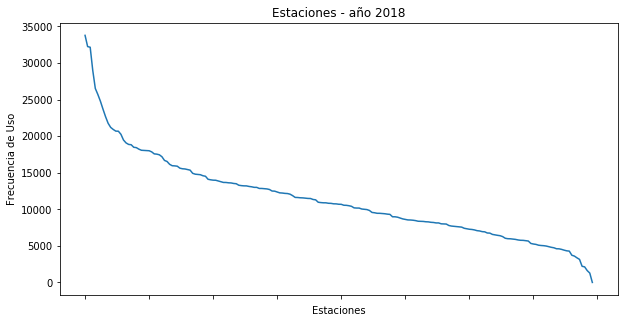

In [5]:
#df['origen_id'].value_counts().sort_values(ascending=False).plot() chequear, ¿porqué el gráfico se vpe distinto?

df['origen_nombre'].value_counts().plot(figsize=(10,5))

plt.title('Estaciones - año 2018')
plt.xlabel('Estaciones')
plt.ylabel('Frecuencia de Uso');

In [6]:
df['origen_nombre'].value_counts()[:3] #filtramos las 3 primeras

Facultad de Medicina    33776
Pacífico                32244
Parque Las Heras        32151
Name: origen_nombre, dtype: int64

Podemos observar que `Facultad de Medicina` es la que tiene la **mayor frecuencia de uso**, es la que usaremos como ejemplo.

In [7]:
df = df[df['origen_nombre'] == 'Facultad de Medicina']

In [8]:
df.shape #verificamos

(33776, 8)

#### 2. Escogemos un mes

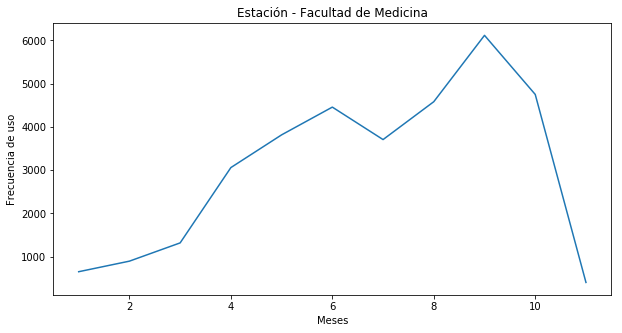

In [9]:
df.groupby(df.index.month)['origen_nombre'].count().plot(figsize=(10,5));
plt.title('Estación - Facultad de Medicina')
plt.ylabel('Frecuencia de uso')
plt.xlabel('Meses');

In [10]:
df.groupby(df.index.month)['origen_nombre'].count().sort_values(ascending=False)[:3]  

bici_fecha_hora_retiro
9     6116
10    4751
8     4583
Name: origen_nombre, dtype: int64

Acorde a nuestro gráfico, el mes de **Septiembre(9)** es el que presenta mayor actividad en la estacion `Facultad de Medicina`.

In [11]:
df = df[df.index.month == 9] #filtramos por mes

In [12]:
df.shape #verificamos

(6116, 8)

#### 3. Derivamos la frecuencia de uso diaria para la estación seleccionada -- Agrupando los Datos

In [121]:
#Remuestreo a 1hs
def resample_data(df):
    '''
    Agrupa el conteo de datos a intervalos de 3 horas.
    '''
    df['conteo'] = 1 #creamos un atributo auxiliar que al sumarse, cuenta la frecuencia de uso dentro del intervalo.
    data_resampled = df.resample("3h").sum().fillna(0)
    return data_resampled.conteo

**Nota** Se puede cambiar el sample a `1h`, pero dada su logitud, no se aprecia bien el gráfico

In [122]:
df_resampled = resample_data(df) # llamamos nuestra función

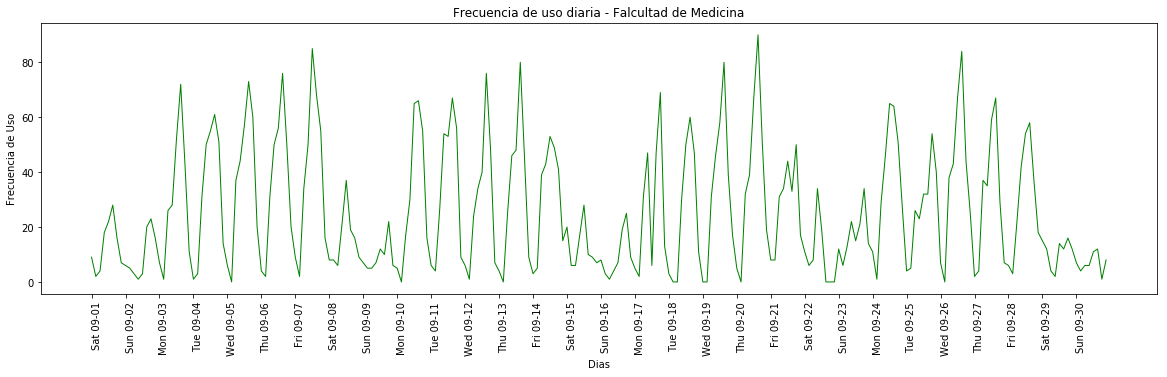

In [123]:
plt.figure(figsize=(20, 5))

#damos formato al eje x
xticks = pd.date_range(start=df_resampled.index.min(), end=df_resampled.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")

#definimos el plot
plt.plot(df_resampled, linewidth=1, color='g')

#agregamos información del gráfico
plt.title('Frecuencia de uso diaria - Falcultad de Medicina')
plt.xlabel("Dias")
plt.ylabel("Frecuencia de Uso");

Observamos un claro patrón donde se distinguen los fines de semana del resto de días.

## Trabajamos con el Modelo

In [128]:
# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    
    #models tools
    from sklearn.model_selection import train_test_split
    
    # split the given features into a training and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    regressor.fit(X_train, y_train)
    
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    n_train = len(y_train)
    

    
    plt.figure(figsize=(20,5))
    
    plt.xticks(range(0, len(X), 25), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
    plt.plot(range(len(y_train)), y_train, label="train",alpha=.3)
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test",alpha=.3)
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Fecha")
    plt.ylabel("Frecuencia de uso")

In [124]:
y = df_resampled.values # extraemos los valores de conteo
X = np.hstack([np.array(df_resampled.index.dayofweek).reshape(-1,1),
               np.array(df_resampled.index.hour).reshape(-1,1)]) #recordando que nuestros datos corresponden a la hora

In [129]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

Test-set R^2: 0.85


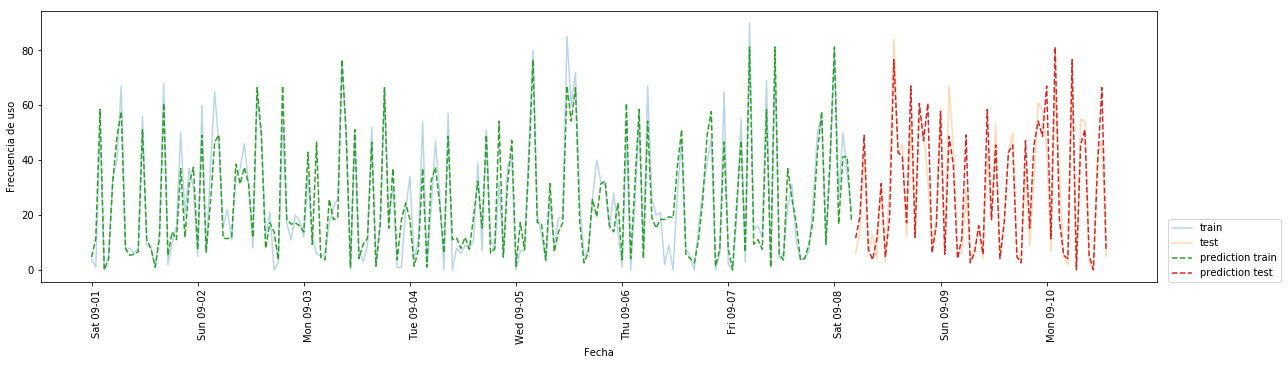

In [130]:
eval_on_features(X, y, regressor) #llamamos nuestra función

### Agregamos el tiempo de uso

In [ ]:
df = df[['origen_nombre','tiempo_uso(s)']]